# Feed Forward Neural Network (FFN)

FFN-er er en av de enkleste formene for nevrale nett. Nettet fungerer ved å sende prediktoren $x$ gjennom $D$ "lag". I hvert lag gjøres først en lineærtransfomrasjon, deretter anvendes en aktiveringsfunksjon $\sigma$ på hver komponent av resultatet fra lineærtransformasjonen. Svaret sendes så videre til neste lag. Til slutt bruker man en slutt-transformasjon, $S$, for å få ut en endelig prediksjon. I symboler betyr dette at

$y(x,\theta) = S\{T_D[T_{D-1}(...T_1\{x\})]\}$,

der $T_d(z) = \sigma(b_d + A_dz)$ er funksjonen som først gjør en lineærtransformasjon av input-en og deretter anvender aktiveringsfunksjonen og $\theta$ er alle parameterene i nettet (altså $b_1,\ldots,b_D,A_1,\ldots,A_d$).

For å implemetere modellen ovenfor, bruker vi en klasse i PyTorch som heter `Module` og lager en underklasse som beskriver nettet vår.

Når man lager en ny underklasse av `Module`, må man definere to ting i klassen for å få alt til å fungere: en funksjon som heter `__init__` og en som heter `forward`. `__init__` er initsialliseringsfunksjonen til den nye klassen vi lager. Denne kalles altså på når en ny instanse av klassen lages og brukes til å sette parametere i klassen. `forward` er funksjonen som regner ut predikert respons for en input $x$. Parameterene i den nevrale nettet regnes ikke som en input til `forward` da disse lagres i klassen. Mer om dette seinere.

`__init__` må ta inn argumentet `self` ellers kan vi bestemme hvilke hyperparametere som er naturlig å sette når man lager en ny instanse av en FFN. Jeg satt de følgende hyperparameterene:
1. `nr_hidden_layers` dette er antall lag i nettverket og $D$ i notasjonen ovenfor
2. `nr_hidden_variables` dette er dimensjonen vektorene i lagene skal ha, altså dimensjonen til $A_dz + b_d$
3. `activation_function` dette er aktiveringsfunksjonen som blir brukt i lagene, $\sigma$ i notasjonen ovenfor.
4. `dim_input` og `dim_output` dette er dimensjonen til kovariaten og responsen henholdsvis. Dette er ikke nødvendig, men gjør kodinga litt enklere.

Under kommer min implementering av `__init__`. Her er det mye som kan gjøres litt annerledes avhengig av smak. Jeg har for eksempel definert slutt transformasjonen, $S$, til å være en lineærkombinasjon av de skjulte variablene i det siste laget. Dette er relativt naturlig for prediksjon, men om man vil gjøre f.eks. klassifikasjon, må dette endres.

In [2]:
import torch

class NeuralNet(torch.nn.Module): #Subklasse av torch.nn.Module
    def __init__(self, dim_input, nr_hidden_layers, nr_hidden_variables, activation_function, final_transformation):
        """
        Ny initsialliseringsfunksjon
        dim_input (int): Dimensjonen til input-variablen (x)
        dim_output (int): Dimensjonen til output-variablen (y)
        nr_hidden_layers (int): Antall skjulte lag
        nr_hidden_variables (int): Antall variabler i hvert hidden layer (z). Her er det like mange i hvert lag
        activation_function (function:R to R): Aktiveringsfunksjonen.
        """
        super().__init__() #Gjør initsialliseringa som må gjøres i superklassen. Dette må man bare gjøre

        #Lag alle lagene i nettet
        self.nr_hidden_layers = nr_hidden_layers #Lagre antall skjule lag som en parameter i klassen
        linear_layers = []
        for i in range(nr_hidden_layers):
            linear_layers += [torch.nn.Linear(nr_hidden_variables, nr_hidden_variables)] #torch.nn.Linear lager en klasse med en affineavbildning fra R^{nr_hidden_variables}\to{R^nr_hidden_variables}

        #Bestem aktiveringsfunksjon
        self.activation = activation_function

        #Bestem første og siste transformasjon
        first_transformation = torch.nn.Linear(dim_input, nr_hidden_variables) #Trengs for å tillate at dimensjonen til kovariatene ikke nødvendigvis er lik antall skjulte variabler
        final_transformation = torch.nn.Linear(nr_hidden_variables,1)

        #Lagre alle lagene i nettverket
        self.layers = torch.nn.ModuleList([first_transformation] + linear_layers + [final_transformation]) #Det er viktig å bruke torch.nn.ModuleList. En vanlig liste fungerer ikke

Nå som vi har initiallisert nettverket, må vi definere hvordan $y(x,\theta)$ skal regnes ut. Dette beskrives i `forward()` Igjen, $\theta$ lagres av nettverket, så det er ikke nødvendig å ha disse som en input.

In [3]:
class NeuralNet(torch.nn.Module): #Subklasse av torch.nn.Module
    def __init__(self, dim_input, nr_hidden_layers, nr_hidden_variables, activation_function):
        """
        Ny initsialliseringsfunksjon
        dim_input (int): Dimensjonen til input-variablen (x)
        nr_hidden_layers (int): Antall skjulte lag
        nr_hidden_variables: Antall variabler i hvert hidden layer (z). Her er det like mange i hvert lag
        activation_function (function:R to R): Aktiveringsfunksjonen. Default er ReLu
        final_transformation (torch.nn klasse): Beskriver hvordan de skjulte variablene skal slås sammen til en prediksjon i siste lag
        """
        super().__init__() #Gjør initsialliseringa som må gjøres i superklassen. Dette må man bare gjøre

        #Lag alle lagene i nettet
        self.nr_hidden_layers = nr_hidden_layers #Lagre antall skjule lag som en parameter i klassen
        linear_layers = []
        for i in range(nr_hidden_layers):
            linear_layers += [torch.nn.Linear(nr_hidden_variables, nr_hidden_variables)] #torch.nn.Linear lager en klasse med en affineavbildning fra R^nr_hidden_variables\to R^nr_hidden_variables
        
        #Bestem aktiveringsfunksjon
        self.activation = activation_function

        #Bestem første og siste transformasjon
        first_transformation = torch.nn.Linear(dim_input, nr_hidden_variables) #Trengs for å tillate at dimensjonen til kovariatene ikke nødvendigvis er lik antall skjulte variabler
        final_transformation = torch.nn.Linear(nr_hidden_variables,1)

        #Lagre alle lagene i nettverket
        self.layers = torch.nn.ModuleList([first_transformation] + linear_layers + [final_transformation]) #Det er viktig å bruke torch.nn.ModuleList. En vanlig liste fungerer ikke

    def forward(self, x):
        """
        x (torch.tensor): input vector
        """
        #Første transformasjon
        # z = self.first_transformation(x)
        z = self.layers[0](x)

        #I hver lag gjør vi sigma(A_dx + b_d)
        for i in range(self.nr_hidden_layers):
            # z = self.linear_layers[i](z)
            z = self.layers[i+1](z)
            z = self.activation(z)

        #Siste transformasjon
        y =  self.layers[-1](z)
        return y

Vi har nå definert et FFN! For et hvert sett med hyperparametere, kan vi nå lage en instanse av klassen. Ved å printe instansen, kan vi se hva strukturen til nettverket er.

In [4]:
#Setter noen parametere for å teste
dim_input = 150
nr_hidden_layers = 5
nr_hidden_variables = 100
activation_function = torch.nn.ReLU()

NN = NeuralNet(dim_input, nr_hidden_layers, nr_hidden_variables, activation_function)
print(f"Model structure: \n{NN}")

Model structure: 
NeuralNet(
  (activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=150, out_features=100, bias=True)
    (1-5): 5 x Linear(in_features=100, out_features=100, bias=True)
    (6): Linear(in_features=100, out_features=1, bias=True)
  )
)


Ovenfor har vi definert strukturen til et FFN. Vi har ikke tilpasset det til data ennå. Vi lager litt simmulert data for dette formålet:

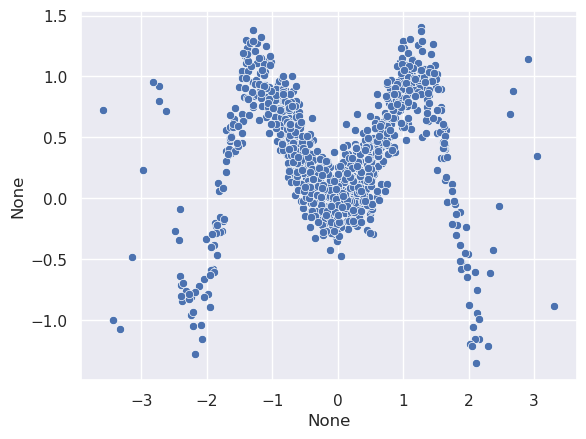

In [5]:
torch.manual_seed(1444)

#Create data
n = 1000
x = torch.randn(n) #Det er veldig viktig å sette requires_grad = False, ellers vil PyTorch tracke gradienten til dataen!
y = torch.sin(x**2) + torch.randn(n)*0.2
data = torch.cat([y.reshape(n,-1), x.reshape(n,-1)], 1)

#Plot data
import matplotlib.pyplot as plt
import seaborn as sns #For penere plot
sns.set_theme() #Set plot-tema til seaborn

sns.scatterplot(x = x, y = y)
plt.show()

Så må vi definere en passende nettverksstruktur. Her er det mange alternativer og man må ofte prøve ut mange kombinasjoner av aktiveringsfunksjoner, antall lag og antall skjulte variabler. Se seksjonen om hyperparametertuning!

In [6]:
#Create NN
dim_input = 1
nr_hidden_layers = 5
nr_hidden_variables = 100
activation_function = torch.nn.ReLU()

NN = NeuralNet(dim_input, nr_hidden_layers, nr_hidden_variables, activation_function)

Før vi kan tilpasset nettet, må vi bestemme oss for hvordan dette skal gjøres. Hvis vi vil finne parameterene som minimerer MSE-en til nettverket aller mest, kan vi bruke en nummerisk optimeringsmetode som f.eks. Newtons metode til å finne den verdien av $\theta$ som gir lavest MSE. Typisk sett gjøres ikke dette. Istedenfor bruker man stochastic gradient descent (SGD). Denne metoden bruker ikke all dataen på en gang, men bruker bare litt av gangen for hver parameteroppdatering innad i den nummeriske optimeringa. Hvor mye som skal brukes på en gang kalles batch size. Hvor mange iterasjoner man skal gjøre kalles epochs. Step size i optimeringa kalles learning rate. 

In [7]:
epochs = 50
batch_size = 50
learning_rate = 1e-1
train_dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True) #Deler data opp i batches

For å kunne bruke SGD, lager vi en instanse av PyTorch-klassen som implementerer denne optimeringsalgoritmen. Dette er en subklasse av den mer generelle klassen `optimizer`. Objekter av `optimizer` klassen tar inn en iterable over parameterene den skal optimere med hensyn på. I tillegg kan man spesifisere andre argumenter hvis ønskelig (eks: læringsrate). Ved å kalle på objektets funksjon `.step()` gjør klassen et optimeringssteg og oppdaterer parameterene i iterablen den har fått inn.

In [8]:
params = NN.parameters() #Det nevrale nettet er automatisk initiallisert med noen vilkårlige variabler satt.
optimizer = torch.optim.SGD(params, lr = learning_rate) #Lager optimereren

Før vi kan tilpasse nettet, må vi også spesifisere hvilken tapsfunksjon vi ønsker at det minimerer. I dette eksemplet, bruker jeg MSE, men det er andre alternativer på [PyTorch sine sider](https://pytorch.org/docs/stable/nn.html#loss-functions).

In [9]:
loss_function = torch.nn.MSELoss() #Loss er MSE

Vi kan nå tilpasse nettet! Dette fungerer som følger. I hver epoke, deler vi opp dataen i batches. Dette gjøres automatisk av PyTorch sin `DataLoader`som vi brukte tidligere. I hver batch bruker vi det nevrale nettet til å predikere responsen i den relevante batchen. Dette blir så brukt til å regne ut tapet i denne batchen, og PyTorch bruker svaret til å gå et steg med optimeringsalgoritmen vi har bygd inn i `optimizer`. Koden under implementerer treningen.

In [10]:
losses = [] #Liste med tap for seinere plotting

#Sett modellen i treningsmodus
NN.train() 
for epoch in range(epochs):
    batch_losses = []
    for batch, data_batch in enumerate(train_dataloader):
        optimizer.zero_grad() #Resetter gradienter, må gjøres for at PyTorch skal få oversikt og ikke blande gradinenter

        #Predikerer responser i batchen
        pred = NN(data_batch[:,1:]) 
        #Beregn tap i batchen
        loss = loss_function(data_batch[:,0:1], pred) 
        
        #Regn ut gradienter
        loss.backward()
        #Gå et optimeringssteg
        optimizer.step() 

        #Lagre tapet i batchen for plotting
        batch_losses += [loss.item()]
    losses += [torch.mean(torch.tensor(batch_losses))]
    

Nå er nettet tilpasset! Plotting av resultat:

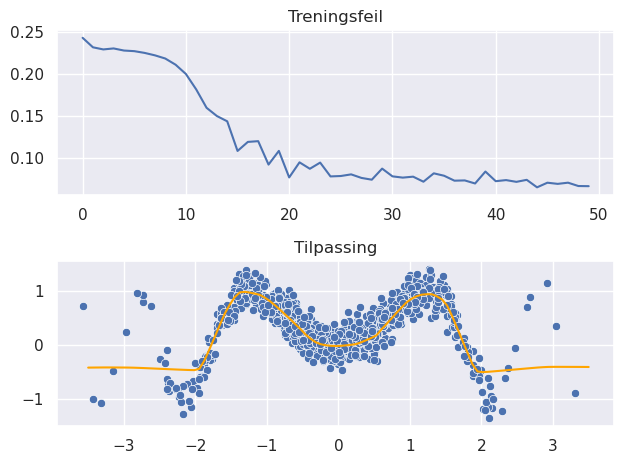

In [11]:
fig, ax = plt.subplots(2,1)
#Plott treningsfeil som en funksjon av antall epoker kjørt
ax[0].plot(range(epochs), losses)
ax[0].set_title("Treningsfeil")

#Plotte prediksjonene til nettet i et relevant område
t = torch.linspace(-3.5,3.5,100)
NN.eval() #Setter modellen i testmodus
preds = NN(t.reshape(-1,1)) #input må være to-dimensjonal

#Plot treningsdata
sns.scatterplot(x = x, y = y, ax = ax[1]) 
ax[1].set_title("Tilpassing")
#Plot prediksjoner
sns.lineplot(x = torch.linspace(-3.5,3.5,100), y = preds.detach().flatten(), ax = ax[1], color = "orange")
ax[1].set_xlabel("")
ax[1].set_ylabel("")

fig.tight_layout()
plt.show()


Det er utrolig mange parametere i nevrale nettverk. Alle disse tilpasses i koden ovenfor og lagers innad i klassen som representerer nettet vårt. Man kan hente ut en iterable med alle parameterene ved å kalle på klassens `parameters()` metode. Denne returnerer en iterable over alle parameterene i nettet, men det er skjeldent man trenger disse, da klassen kan regne ut prediksjonen automatisk uten at man må sende inn parameterene som ble funnet i tilpassinga.

Når det er sagt, er det et veldig viktig tilfelle der man må ha et bevisst forhold til parameterene til det nevrale nettet. Det er når man skal lagre og laste modeller. Tilpassing av dype læringsmetoder kan ta lang tid, ofte flere timer eller dager. Det er derfor nødvendig å kunne lagre den tilpassede modellen etter man har trent den opp. Dette kan gjøres med PyTorch sin `torch.save` funksjon. Man kan sende inn hele modellen til denne funksjonen, men det er bedre bare å lagre parameterene.

In [12]:
torch.save(NN.state_dict(), "FFN_params")

Hvis vi seinere vil komme tilbake til denne modellen, er det bare å laste inn parameterene og initiallisere et nytt nettverk med dem. Vi slipper da å trene modellen på nytt.

In [13]:
NN_new = NeuralNet(1, nr_hidden_layers, nr_hidden_variables, torch.nn.ReLU())
NN_new.load_state_dict(torch.load("FFN_params", weights_only=True)) #weight_only = True fordi bare parametere ble lagret, ikke hele modellen

#Evaluerer modellen på ny data
NN_new.eval() #Sett modellen i evalueringsmodus
new_preds = NN_new(torch.linspace(-1,1,100).reshape(-1,1)) #Prediker nye observasjoner

## Forbedringer og kommentarer

Her kommer et par kommentarer om ting man kan tenke på når man skal gjøre dyp læring i PyTorch.

### CUDA
PyTorch kommer innebygd med evnen til å kjøre koden på GUP-er. Dette kan gjøre alt mye raskere. Hvis alt er blitt installert riktig skal dette være mulig å gjøre på samba8-serveren til NR, men også laptopene våre kan ha tilgang på en GUP som koden kan kjøres på (dette gjelder i alle fall min laptop). For å sjekke om en CUDA funksjonallitet er tilgjengelig på systemet, kjør følgende kommando.

In [14]:
torch.cuda.is_available()

True

Hvis CUDA-funksjonallitet er tilgjengelig, er det overraskende lett å ta det i bruk i PyTorch. For å gjøre dette, må vi lage et `device` som vi kan flytte alle tensorene og klassene våre til.

In [15]:
device = torch.device("cuda")

Det kan være lurt å starte programmene med en if test slik at CUDA brukes om tilgjengelig, men ikke ellers.

In [16]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Vi bruker GPU: {torch.cuda.get_device_name()}")
else:
    device = torch.device("cpu")
    print(f"Ingen GPU tilgjengelig. Jobber på CPUen")

Vi bruker GPU: NVIDIA GeForce RTX 3090


For å gjøre en operasjon på GUP-en, holder det å flytte alle tensorer og klasser vi bruker dit. Koden skal så automatisk kjøres med CUDA funksjon.

In [17]:
def fit(x_train, y_train, device):
    NN = NeuralNet(dim_input, nr_hidden_layers, nr_hidden_variables, activation_function).to(device)
    x_train = x_train.to(device)
    y_train = y_train.to(device)

    #Setter parametere
    epochs = 20
    batch_size = 32
    data = torch.cat([y_train.reshape(-1,1), x_train.reshape(-1,1)], 1)
    train_dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True) #Deler data opp i batches

    #Lager optimerer
    params = NN.parameters() #Det nevrale nettet er automatisk initiallisert med noen vilkårlige variabler satt.
    optimizer = torch.optim.SGD(params, lr=1e-3)

    #Lager loss
    loss_function = torch.nn.MSELoss()

    #Tilpasser modellen
    losses = [] 

    NN.train() 
    for epoch in range(epochs):
        batch_losses = []
        for batch, data_batch in enumerate(train_dataloader):
            optimizer.zero_grad() #Resetter gradienter, må gjøres for at PyTorch skal få oversikt og ikke blande gradinenter

            #Predikerer responser i batchen
            pred = NN(data_batch[:,1:]) 
            #Beregn tap i batchen
            loss = loss_function(data_batch[:,0:1], pred) 
            
            #Regn ut gradienter
            loss.backward()
            #Gå et optimeringssteg
            optimizer.step() 

            #Lagre tapet i batchen for plotting
            batch_losses += [loss.item()]
        losses += [torch.mean(torch.tensor(batch_losses))]

    return torch.mean(torch.tensor(losses))

import time
device = torch.device("cpu")
t = time.time()
fit(x, y, device=device)
print(f"Time CPU: {time.time() - t}")

device = torch.device("cuda")
t = time.time()
fit(x, y, device=device)
print(f"Time CUDA: {time.time() - t}")


Time CPU: 0.41966891288757324
Time CUDA: 0.7392232418060303


### ADAM

Adam er en slags utglattet versjon av stochastic gradient descent som skal være både er raskere og mer stabil særlig for store og komplekse datasett. Det er derfor often denne optimaliseringsalgoritemen som brukes i praksis heller en standard SGD.

Det er veldig lett å bytte fra SDG til ADAM. Det eneste vi må gjøre er å erstatte linja `optimizer = torch.optim.SGD(params)` med  `optimizer = torch.optim.Adam(params)`, ellers er koden helt lik. Scripte under tilpasser et nevralt nett til dataen ovenfor ved hjelp av ADAM.

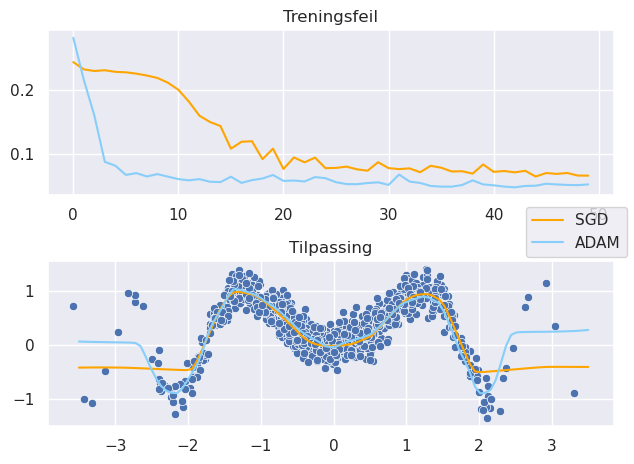

In [18]:
NN_ADAM = NeuralNet(dim_input, nr_hidden_layers, nr_hidden_variables, activation_function).to(device)

#Setter parametere
train_dataloader = torch.utils.data.DataLoader(data.to(device), batch_size=batch_size, shuffle=True) #Deler data opp i batches

#Lager optimerer
params_ADAM = NN_ADAM.parameters() #Det nevrale nettet er automatisk initiallisert med noen vilkårlige variabler satt.
optimizer_ADAM = torch.optim.Adam(params_ADAM)

#Lager loss
loss_function = torch.nn.MSELoss()

#Tilpasser modellen
losses_ADAM = [] 

NN_ADAM.train() 
for epoch in range(epochs):
    batch_losses = []
    for batch, data_batch in enumerate(train_dataloader):
        optimizer_ADAM.zero_grad() #Resetter gradienter, må gjøres for at PyTorch skal få oversikt og ikke blande gradinenter

        #Predikerer responser i batchen
        pred = NN_ADAM(data_batch[:,1:]) 
        #Beregn tap i batchen
        loss = loss_function(data_batch[:,0:1], pred) 
        
        #Regn ut gradienter
        loss.backward()
        #Gå et optimeringssteg
        optimizer_ADAM.step() 

        #Lagre tapet i batchen for plotting
        batch_losses += [loss.item()]
    losses_ADAM += [torch.mean(torch.tensor(batch_losses))]

#Plotting
fig, ax = plt.subplots(2,1)
#Plott treningsfeil som en funksjon av antall epoker kjørt
ax[0].plot(range(epochs), losses, color = "orange")
ax[0].plot(range(epochs), torch.tensor(losses_ADAM), color = "lightskyblue")
ax[0].set_title("Treningsfeil")
fig.legend(["SGD", "ADAM"], loc = "center right")

#Plotte prediksjonene til nettet i et relevant område
t = torch.linspace(-3.5,3.5,100)
NN_ADAM.eval() #Setter modellen i testmodus
preds_ADAM = NN_ADAM(t.reshape(-1,1).to(device)) #input må være to-dimensjonal

#Plot treningsdata
sns.scatterplot(x = x, y = y, ax = ax[1]) 
ax[1].set_title("Tilpassing")
#Plot prediksjoner
sns.lineplot(x = torch.linspace(-3.5,3.5,100), y = preds.detach().flatten(), ax = ax[1], color = "orange")
sns.lineplot(x = torch.linspace(-3.5,3.5,100), y = preds_ADAM.to("cpu").detach().flatten(), ax = ax[1], color = "lightskyblue")
ax[1].set_xlabel("")
ax[1].set_ylabel("")
fig.tight_layout()
plt.show()

Forskjellene er kanskje ikke enorme, men dette datasettet er lite og enkelt og stiller derfor ADAM i et litt dårligere lys enn det metoden fortjener. Med større og mer høydimensjonale datasett, kan ADAM kan gi lavere feil og kjøre fortere. Så prøv ut denne optimeringsmetoden hvis SGD fungerer dårlig!

### Hyperparametertilpassing


Tilpassingen ovenfor krever at man setter utrolig mange hyperparametere. Læringsrate, antall lag, antall noder i hvert lag, aktiveringsfunksjon, batch size og antall epoker må alle bestemmes for at rammeverket ovenfor skal fungere. En måte å gjøre dette på er bare å prøve seg fram og sette noen parametere som ser ut til å fungere (slik jeg har gjort ovenfor), men det er bedre måter å gå fram på. En slik måte er å bruke pakken `optuna`. Denne pakken har implementert flere smarte framgangsmåter for å lete etter optimale hyperparametere.

Vi begynner med bare å skru på én parameter: antall skjulte lag. Optuna leter gjennom parameterrommet etter de beste hyperparameterene. For at pakken skal klare å gjøre dette, må vi kode inn en tapsfunksjon som optuna kan bruke til å evaluere `tapet' ved å bruke et set med hyperparametere. Vi begynner med å kode inn en funksjon som tilpasser det nevrale nettet gitt en hyperparameter

In [19]:
#Implementerer en funksjon som tilpasser modellen med et gitt sett hyperparametere
def tilpass_NN(antall_lag, x, y, device):
    #Lag nettet
    NN = NeuralNet(dim_input, antall_lag, nr_hidden_variables, torch.nn.ReLU()).to(device)

    #Setter parametere
    epochs = 50
    batch_size = 50
    learning_rate = 1e-1
    data = torch.cat([y.reshape(-1,1), x.reshape(-1,1)], 1)
    train_dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True) #Deler data opp i batches

    #Lager optimerer
    params = NN.parameters() #Det nevrale nettet er automatisk initiallisert med noen vilkårlige variabler satt.
    optimizer = torch.optim.Adam(params)

    #Lager loss
    loss_function = torch.nn.MSELoss()

    #Tilpasser modellen
    NN.train() #Setter modellen i treningsmodus
    for epoch in range(epochs):
        for batch, data_batch in enumerate(train_dataloader):
            optimizer.zero_grad() #Resetter gradienter

            #Predikerer responser i batchen
            pred = NN(data_batch[:,1:]) 
            #Beregn tap i batchen
            loss = loss_function(data_batch[:,0:1], pred) 
            
            #Regn ut gradienter
            loss.backward()
            #Gå et optimeringssteg
            optimizer.step() 
        
    return NN


Vi kan nå kode inn en funksjon som beregneter tapet til en hyperparameter ved først å tilpasse det korresponderende nevrale nettet og deretter regnet ut dets MSE på treningssettet.

In [20]:
#Tapsfunksjon
def taps_func(NN, x, y):
    loss_function = torch.nn.MSELoss() #MSE er loss

    NN.eval() #Setter modellen i testmodus
    preds = NN(x.reshape(-1,1)) #Prediker med modellen
    MSE_train = loss_function(preds, y.reshape(-1,1)).item() #Beregn treningsfeil, veldig viktig å shape y

    return MSE_train

Nå kan vi be optuna lete gjennom parameterrommet etter et bra sett med hyperparametere. Dette gjør optuna ved å prøve seg fram med parametere, og man må derfor kode inn en funksjon som evaluerer ethvert gjett.

In [21]:
#Funksjon for optuna
def objective(trial, x, y):
    antall_lag = trial.suggest_int("antall_lag", 1, 25) #Velg en hyperparameter mellom 1 og 25
    NN = tilpass_NN(antall_lag, x, y, device) #Tilpass det tilhørende nettet

    return taps_func(NN, x, y) #Regn ut tapet


#Velge optimale tuningparametere
import optuna

#Flytt x og y til cpu-en når mulig for raskere kode
x = x.to(device)
y = y.to(device)

#Lag en studie
study = optuna.create_study(direction = "minimize") #Minimize for å minimere tap, maximize for å maksimere en funksjon

#Gjennomfør studien
study.optimize(lambda trial: objective(trial, x, y), n_trials=10) #n_trials er antall hyperparametere optuna prøver ut

/home/michael/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-11-13 13:23:15,841] A new study created in memory with name: no-name-7862193c-012c-423c-98ee-6b8557a6deb7
[I 2024-11-13 13:23:18,692] Trial 0 finished with value: 0.23110225796699524 and parameters: {'antall_lag': 22}. Best is trial 0 with value: 0.23110225796699524.
[I 2024-11-13 13:23:19,442] Trial 1 finished with value: 0.057656608521938324 and parameters: {'antall_lag': 2}. Best is trial 1 with value: 0.057656608521938324.
[I 2024-11-13 13:23:20,192] Trial 2 finished with value: 0.056291840970516205 and parameters: {'antall_lag': 2}. Best is trial 2 with value: 0.056291840970516205.
[I 2024-11-13 13:23:21,027] Trial 3 finished with value: 0.05074654892086983 and parameters: {'antall_lag': 3}. Best is tr

En oversikt over hva optuna har gjort kan hentes ut fra objektet `study`

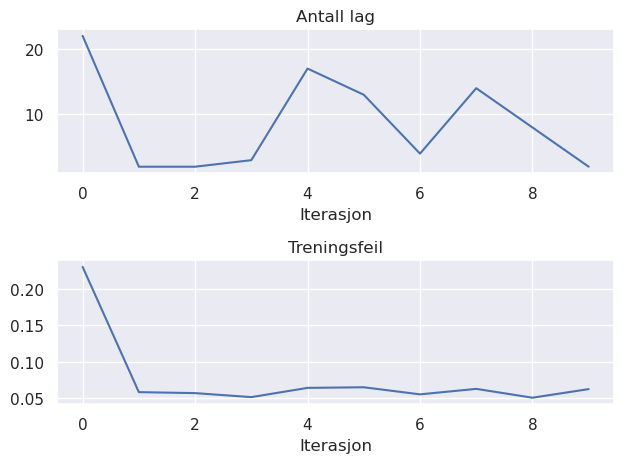

In [22]:
#Lager en liste med MSEer beregnet og antall_lag brukt
trials = study.trials
antall_lags = []
MSEs = []
for trial in trials:
    MSEs += [trial.value]
    antall_lags += [trial.params["antall_lag"]]

#Plotting
fig, ax = plt.subplots(2,1)
sns.lineplot(x = range(len(antall_lags)), y = antall_lags, ax = ax[0])
ax[0].set_title("Antall lag")
ax[0].set_xlabel("Iterasjon")
sns.lineplot(x = range(len(antall_lags)), y = MSEs, ax = ax[1])
ax[1].set_title("Treningsfeil")
ax[1].set_xlabel("Iterasjon")
fig.tight_layout()
plt.show()


Den beste hyperparameteren kan også hentes ut fra `study`.

Best trial: 8
Best MSE: 0.049941305071115494
Best hyperparameters: {'antall_lag': 8}


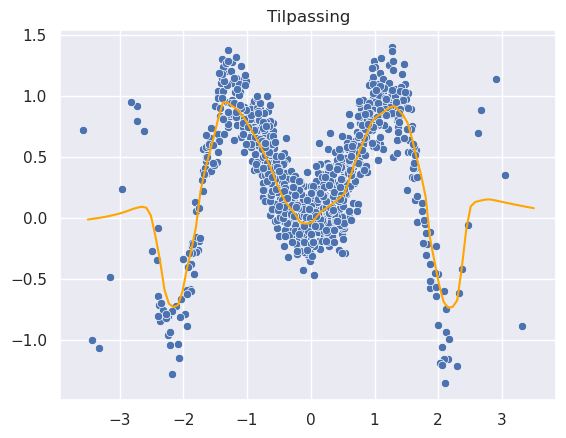

In [23]:
print("Best trial:", study.best_trial.number)
print("Best MSE:", study.best_trial.value)
print("Best hyperparameters:", study.best_params)

#Den beste tilpassinga
NN = tilpass_NN(study.best_params["antall_lag"], x, y, device)

#Plotte prediksjonene til det beste i et relevant område
t = torch.linspace(-3.5,3.5,100)
NN.eval() #Setter modellen i testmodus
preds = NN(t.reshape(-1,1).to(device)).to("cpu") #Flytt til cpu for plotting

#Plot treningsdata
sns.scatterplot(x = x.to("cpu"), y = y.to("cpu")) 
plt.title("Tilpassing")
#Plot prediksjoner
sns.lineplot(x = torch.linspace(-3.5,3.5,100), y = preds.detach().flatten(), color = "orange")
plt.xlabel("")
plt.ylabel("")

plt.show()

Optuna sjekker ikke alle mulige hyperparametere. Den prøver å gjøre et slags smart søk gjennom mulige valg ved å trekker tilfeldige hyperparametere og sjekke disse. Hvis man ikke spesifiserer noe, velger pakken automatisk en måte å trekke hyperparametere på, men det er mulig å bruke andre framgangsmetoder. [Nettsidene til pakken](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html) har en liste over mulige framgangsmåter, men det er også mulig å lage sine egne! Koden under viser hvordan man kan bytte sampler til en som trekker hyperparamere tilfeldig.

In [24]:
#Spesifiser en måte å trekke hyperparametere på
sampler = optuna.samplers.RandomSampler(1444)
#Lag en studie
study = optuna.create_study(direction = "minimize") 
#Gjennomfør studien
study.optimize(lambda trial: objective(trial, x, y), n_trials=2)

[I 2024-11-13 13:29:59,149] A new study created in memory with name: no-name-b9826a18-f5df-4e7a-ae13-ac57adbfabd0
[I 2024-11-13 13:30:03,115] Trial 0 finished with value: 0.23089773952960968 and parameters: {'antall_lag': 22}. Best is trial 0 with value: 0.23089773952960968.
[I 2024-11-13 13:30:03,951] Trial 1 finished with value: 0.057388946413993835 and parameters: {'antall_lag': 2}. Best is trial 1 with value: 0.057388946413993835.


I koden ovenfor har vi bare brukt optuna til å velge antall lag i det nevrale nettet, men det er mange andre hyperparametere som også kunne blitt tunet. Vi har for eksempel ikke brukt pakken til å bestemme oss for antall skjulte variabler, læringsraten til ADAM eller aktiveringsfunksjon. Under kommer en kode som viser hvordan også disse parameterene kan tunes med optuna.

**Dette tar litt tid å kjøre** (3 min på min laptop)
Juster n_trials for å få det til å gå fortere.

In [25]:
#Implementerer en funksjon som tilpasser modellen med et gitt sett hyperparametere
def tilpass_NN(antall_lag, antall_skjulte_var, learning_rate, activation_function, x, y, device):
    #Lag nettet
    NN = NeuralNet(dim_input, antall_lag, antall_skjulte_var, activation_function).to(device)

    #Setter parametere
    epochs = 50
    batch_size = 50
    data = torch.cat([y.reshape(-1,1), x.reshape(-1,1)], 1)
    train_dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True) #Deler data opp i batches

    #Lager optimerer
    params = NN.parameters() #Det nevrale nettet er automatisk initiallisert med noen vilkårlige variabler satt.
    optimizer = torch.optim.Adam(params, lr = learning_rate)

    #Lager loss
    loss_function = torch.nn.MSELoss()

    #Tilpasser modellen
    NN.train() #Setter modellen i treningsmodus
    for epoch in range(epochs):
        for batch, data_batch in enumerate(train_dataloader):
            optimizer.zero_grad() #Resetter gradienter

            #Predikerer responser i batchen
            pred = NN(data_batch[:,1:]) 
            #Beregn tap i batchen
            loss = loss_function(data_batch[:,0:1], pred) 
            
            #Regn ut gradienter
            loss.backward()
            #Gå et optimeringssteg
            optimizer.step() 
        
    return NN

#Tapsfunksjon
def taps_func(NN, x, y):
    loss_function = torch.nn.MSELoss() #MSE er loss

    NN.eval() #Setter modellen i testmodus
    preds = NN(x.reshape(-1,1)) #Prediker med modellen
    MSE_train = loss_function(preds, y.reshape(-1,1)).item() #Beregn treningsfeil, veldig viktig å shape y

    return MSE_train

#Funksjon for optuna
def objective(trial, x, y):
    antall_lag = trial.suggest_int("antall_lag", 1, 25) 
    antall_skjulte_var = trial.suggest_int("antall_skjulte_var", 50, 200)
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1, log = True) #Siden læringsraten settes i størrelsesorden setter vi log = True
    activation_function = trial.suggest_categorical("activation_function", ["relu", "sigmoid"])
    if activation_function == "relu":
        activation_function = torch.nn.ReLU()
    else:
        activation_function = torch.nn.Sigmoid()
    NN = tilpass_NN(antall_lag, antall_skjulte_var, learning_rate, activation_function, x, y, device) #Tilpass det tilhørende nettet

    return taps_func(NN, x, y) #Regn ut tapet


#Velge optimale tuningparametere
import optuna

#Flytt x og y til cpu-en når mulig for raskere kode
x = x.to(device)
y = y.to(device)

#Lag en studie
study = optuna.create_study(direction = "minimize") #Minimize for å minimere tap, maximize for å maksimere en funksjon

#Gjennomfør studien
study.optimize(lambda trial: objective(trial, x, y), n_trials=25) #n_trials er antall hyperparametere optuna prøver ut

[I 2024-11-13 13:30:56,299] A new study created in memory with name: no-name-a1001d37-8d82-424b-ba37-2e8dcf4af9d2
[I 2024-11-13 13:31:00,057] Trial 0 finished with value: 0.23135697841644287 and parameters: {'antall_lag': 20, 'antall_skjulte_var': 106, 'learning_rate': 0.016054813844711458, 'activation_function': 'relu'}. Best is trial 0 with value: 0.23135697841644287.
[I 2024-11-13 13:31:01,882] Trial 1 finished with value: 0.23570115864276886 and parameters: {'antall_lag': 6, 'antall_skjulte_var': 94, 'learning_rate': 0.05556332692626241, 'activation_function': 'relu'}. Best is trial 0 with value: 0.23135697841644287.
[I 2024-11-13 13:31:02,699] Trial 2 finished with value: 0.43364810943603516 and parameters: {'antall_lag': 1, 'antall_skjulte_var': 159, 'learning_rate': 0.8033947880663116, 'activation_function': 'sigmoid'}. Best is trial 0 with value: 0.23135697841644287.
[I 2024-11-13 13:31:03,486] Trial 3 finished with value: 0.14993658661842346 and parameters: {'antall_lag': 1, '

Igjen kan vi se hvordan optuna har tenkt.

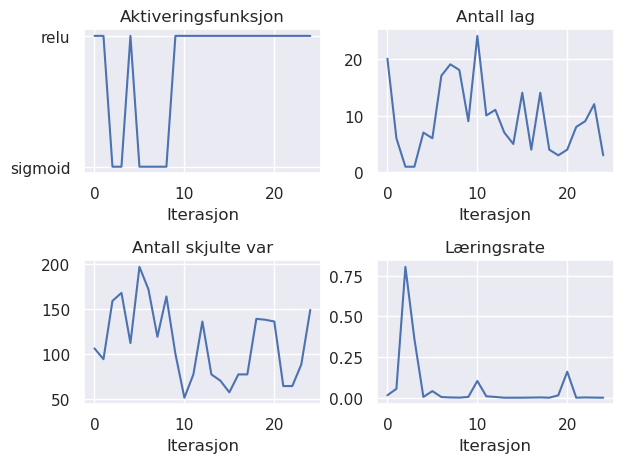

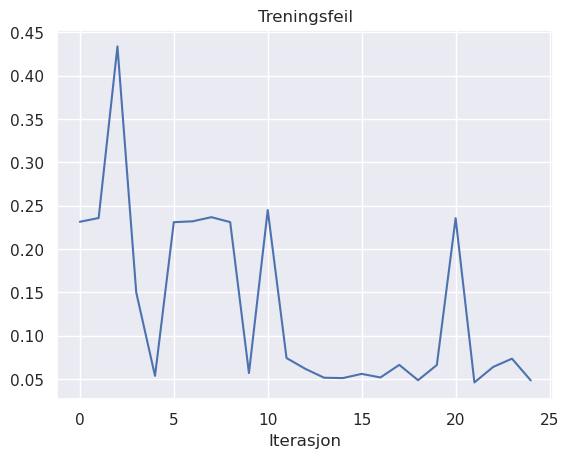

In [26]:
#Lager en liste med MSEer beregnet og antall_lag brukt
trials = study.trials
antall_lags = []
antall_skjulte_vars = []
learning_rates = []
activation_functions = []
MSEs = []
for trial in trials:
    MSEs += [trial.value]
    antall_lags += [trial.params["antall_lag"]]
    antall_skjulte_vars += [trial.params["antall_skjulte_var"]]
    learning_rates += [trial.params["learning_rate"]]
    activation_functions += [trial.params["activation_function"]]

import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(2,2)
sns.lineplot(x = range(len(antall_lags)), y = activation_functions, ax = ax[0,0])
ax[0,0].set_title("Aktiveringsfunksjon")
ax[0,0].set_xlabel("Iterasjon")
sns.lineplot(x = range(len(antall_lags)), y = antall_lags, ax = ax[0,1])
ax[0,1].set_title("Antall lag")
ax[0,1].set_xlabel("Iterasjon")
sns.lineplot(x = range(len(antall_skjulte_vars)), y = antall_skjulte_vars, ax = ax[1,0])
ax[1,0].set_title("Antall skjulte var")
ax[1,0].set_xlabel("Iterasjon")
sns.lineplot(x = range(len(learning_rates)), y = learning_rates, ax = ax[1,1])
ax[1,1].set_title("Læringsrate")
ax[1,1].set_xlabel("Iterasjon")
fig.tight_layout()
plt.show()

sns.lineplot(x = range(len(antall_lags)), y = MSEs)
plt.title("Treningsfeil")
plt.xlabel("Iterasjon")
plt.show()

Og vi kan plotte den beste tilpassingen sammen med vårt tidligere tilpassede nett.

Best trial: 21
Best MSE: 0.045975469052791595
Best hyperparameters: {'antall_lag': 8, 'antall_skjulte_var': 64, 'learning_rate': 0.0011254927211459358, 'activation_function': 'relu'}


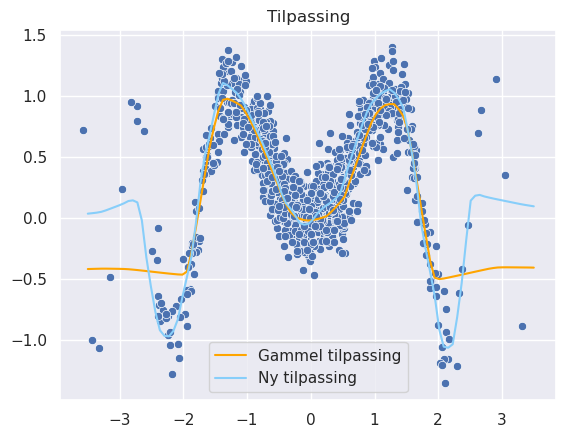

In [27]:
print("Best trial:", study.best_trial.number)
print("Best MSE:", study.best_trial.value)
print("Best hyperparameters:", study.best_params)

#Den beste tilpassinga
if study.best_params["activation_function"] == "relu":
    activation_function = torch.nn.ReLU()
else:
    activation_function = torch.nn.Sigmoid()
NN = tilpass_NN(study.best_params["antall_lag"], study.best_params["antall_skjulte_var"], study.best_params["learning_rate"], activation_function, x, y, device)

#Plotte prediksjonene til det beste i et relevant område
t = torch.linspace(-3.5,3.5,100)
NN.eval() #Setter modellen i testmodus
preds = NN(t.reshape(-1,1).to(device)).to("cpu") #Flytt til cpu for plotting

#Henter du det gamle nettet
NN_new = NeuralNet(1, nr_hidden_layers, nr_hidden_variables, torch.nn.ReLU())
NN_new.load_state_dict(torch.load("FFN_params", weights_only=True))
old_preds = NN_new(torch.linspace(-3.5,3.5,100).reshape(-1,1)) #Prediker nye observasjoner

#Plot treningsdata
sns.scatterplot(x = x.to("cpu"), y = y.to("cpu")) 
plt.title("Tilpassing")
#Plot prediksjoner
sns.lineplot(x = torch.linspace(-3.5,3.5,100), y = old_preds.detach().flatten(), color = "orange", label = "Gammel tilpassing")
sns.lineplot(x = torch.linspace(-3.5,3.5,100), y = preds.detach().flatten(), color = "lightskyblue", label = "Ny tilpassing")
plt.xlabel("")
plt.ylabel("")

plt.legend()

plt.show()